# CS7641 Machine Learning

### Assignment 3 - Unsupervised Learning
### Author: Vivek Agrawal


### References



## 1. Data Sets Used
First step in the process is to load all the datasets
1. https://archive.ics.uci.edu/ml/datasets/Census+Income
1. https://archive.ics.uci.edu/ml/datasets/Wine+Quality

In [1]:
#Imports
import pandas as pd
import numpy as np
import itertools 
from scipy.stats import kurtosis

from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm


import matplotlib.pyplot as plt
from time import clock
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from collections import defaultdict
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import homogeneity_score, completeness_score, homogeneity_completeness_v_measure
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.random_projection import SparseRandomProjection
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.base import TransformerMixin,BaseEstimator
import warnings
warnings.simplefilter('ignore')
from sklearn.preprocessing import scale


# Data Cleanup

In [2]:
def gtid():
    return 903471711

def author(self):
    return 'vagrawal63'	

  
def get_income_data(file_name = "adult.csv"):
    data = pd.read_csv(file_name)
    #clean rows with empty values 
    data = data[data.occupation.str.strip() != '?']
    data = data[data.workclass.str.strip() != '?']
    data = data[data.nativecountry.str.strip() != '?']
    #convert income to binary classes
    def func(x):
        if(x == " <=50K" or x == " <=50K."):
            return 0
        elif(x == " >50K" or x == ' >50K.'):
            return 1
    data['income'] = data['income'].apply(func)
    #print(data.head())
    result = data['income']
    del data['income']
    del data['education']
    del data['fnlwgt']
    #testing if I want to delete these additional columns
    # result: Tree size drops from Cleaned: (45222, 486) to (45222, 268)
    # accuracy drops from Accuracy of tree (No pruning):0.823377120460988 to 0.7842997385726206
    del data['capitalgain']
    del data['capitalloss']
    #encode to binary values
    #enc = OneHotEncoder(sparse = False, handle_unknown='ignore')
    #data = enc.fit_transform(data)
    data = pd.get_dummies(data, columns=['workclass','maritalstatus','occupation',
                                         'relationship','race',
                                         'gender','nativecountry'])
    
    #print(enc.categories_)
    data = scale(data)
    return data, result


#randomize using GT ID
np.random.seed(gtid())
#Read Data File
income_data, result = get_income_data()
print("Cleaned: " + str(income_data.shape))

Cleaned: (45222, 85)


In [3]:
print("Split data")
#split data
X_train, X_test, Y_train, Y_test = train_test_split(income_data, result, test_size  = 0.2)
print("X_train: " + str(X_train.shape))

Split data
X_train: (36177, 85)


## Part 1: K Means and GMM (Expectation Maximization)

In [4]:
print('Part 1: Start Clustering on Income Data ==')
clusters =  [2,4,6,8,10,12,14,16,18,20,25,30]


SSE = defaultdict(dict)
BIC = defaultdict(dict)
hScore = defaultdict(dict)
cScore = defaultdict(dict)
AMI = defaultdict(dict)
VMeasure = defaultdict(dict)
km = KMeans(random_state=5)
gmm = GaussianMixture(random_state = 100)

st = clock()
for k in clusters:
    km.set_params(n_clusters=k)
    gmm.set_params(n_components=k)
    
    km.fit(X_train)
    gmm.fit(X_train)

    SSE[k]['IncomeInertia'] = (km.inertia_)
    BIC[k]['IncomeBIC'] = gmm.bic(X_train)
    
    hScore[k]['KM'] = homogeneity_score(Y_train,km.predict(X_train))
    hScore[k]['GMM'] = homogeneity_score(Y_train,gmm.predict(X_train))
    
    cScore[k]['KM'] = completeness_score(Y_train,km.predict(X_train))
    cScore[k]['GMM'] = completeness_score(Y_train,gmm.predict(X_train))
    
    AMI[k]['KM'] = ami(Y_train,km.predict(X_train))
    AMI[k]['GMM'] = ami(Y_train,gmm.predict(X_train))
    
    
    a,b,vm = homogeneity_completeness_v_measure(Y_train,km.predict(X_train))
    VMeasure[k]['KM'] = vm
    
    a,b,vm = homogeneity_completeness_v_measure(Y_train,gmm.predict(X_train))
    VMeasure[k]['GMM'] = vm
    
    
SSE = (pd.DataFrame(SSE)).T
BIC = pd.DataFrame(BIC).T

hScore = pd.DataFrame(hScore).T 
cScore = pd.DataFrame(cScore).T
AMI = pd.DataFrame(AMI).T
VMeasure = pd.DataFrame(VMeasure).T

print("Writing files now .. ")
SSE.to_csv('./P1/IncomeClusterKMeans.csv')
BIC.to_csv('./P1/IncomeClusterGMM.csv')

hScore.to_csv('./P1/IncomeHScore.csv')
cScore.to_csv('./P1/IncomeCScore.csv')
AMI.to_csv('./P1/IncomeAMI.csv')
VMeasure.to_csv('./P1/IncomeVMeasure.csv')
print("Finished writing files")

Part 1: Start Clustering on Income Data ==
Writing files now .. 
Finished writing files


In [5]:
def plot_clustering_charts():

    
    KNNCluster = pd.read_csv("./P1/IncomeClusterKMeans.csv", header='infer')
    GMMCluster = pd.read_csv("./P1/IncomeClusterGMM.csv", header='infer')

    HScore = pd.read_csv("./P1/IncomeHScore.csv", header = 'infer')
    CScore = pd.read_csv("./P1/IncomeCScore.csv", header = 'infer')
    AMI = pd.read_csv("./P1/IncomeAMI.csv", header = 'infer')

    VMeasure = pd.read_csv("./P1/IncomeVMeasure.csv", header = 'infer')

    x_data = HScore['Unnamed: 0']
    plt.close()
    plt.plot(x_data, KNNCluster['IncomeInertia'], 'bx-', color = 'blue', linewidth = 1, label = "Number of Clusters" )
    plt.axvline(x = 6, linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 6")
    plt.legend(loc = 'best')
    plt.title("Figure 1.1: KMeans Elbow Method\nIncome Dataset")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Sum of Squared Distances");
    plt.show()
    plt.close()

    plt.plot(x_data, HScore['KM'], color = 'orange',  label = "Homogenity" )
    plt.plot(x_data, CScore['KM'], color = 'blue',  label = "Completeness" )
    plt.plot(x_data, AMI['KM'], color = 'green',  label = "Adjusted MI" )
    plt.plot(x_data, VMeasure['KM'], color = 'red',  label = "V Measure" )
    plt.axvline(x = 6 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 6")

    plt.legend(loc = 'upper right')
    plt.title("Figure 1.2: KMeans Performance Evaluation\nIncome Dataset")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score");
    plt.show()
    plt.close()

    plt.plot(x_data, GMMCluster['IncomeBIC'], 'bx-', color = 'blue', linewidth = 1, label = "Number of Clusters" )
    plt.axvline(x = 8 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 8")
    plt.legend(loc = 'best')
    plt.title("Figure 2.2: Expectation Maximization BIC\nIncome Dataset")
    plt.xlabel("Number of Clusters")
    plt.ylabel("BIC");
    plt.show()
    plt.close()

    plt.plot(x_data, HScore['GMM'], color = 'orange',  label = "Homogenity" )
    plt.plot(x_data, CScore['GMM'], color = 'blue',  label = "Completeness" )
    plt.plot(x_data, AMI['GMM'], color = 'green',  label = "Adjusted MI" )
    plt.plot(x_data, VMeasure['GMM'], color = 'red',  label = "V Measure" )
    plt.axvline(x = 8 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Clusters = 8")
    plt.legend(loc = 'upper right')
    plt.title("Figure 2.2: Expectation Maximization Performance Evaluation\nIncome Dataset")
    plt.xlabel("Number of Clusters")
    plt.ylabel("Score");
    plt.show()
    plt.close()

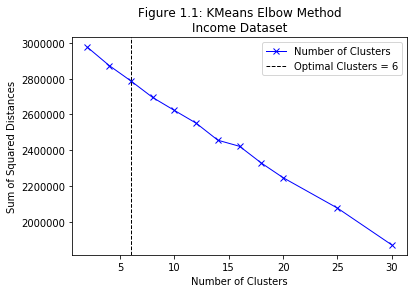

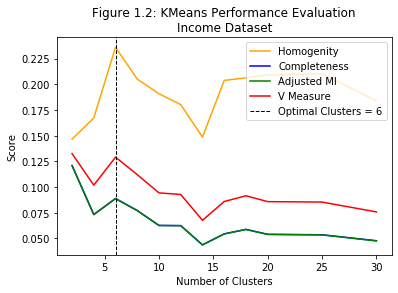

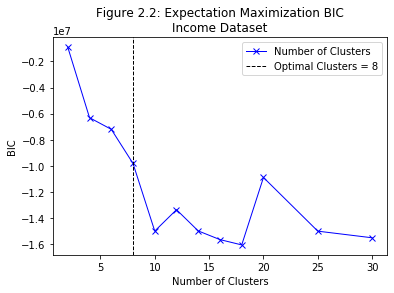

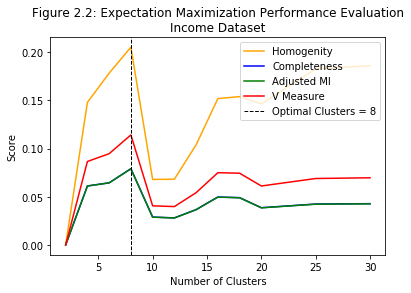

In [6]:
plot_clustering_charts()

In [7]:
def KM_Silhoutte(X, y, title=""):
    if (title == ""):
        title = "Figure 1.3: KMeans Clustering Silhoutte Analysis\nIncome Dataset "
# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


    range_n_clusters = [2,4,6,8,10,12,14,16,18,20,25,30]

    for n_clusters in range_n_clusters:
        # Create a subplot with 1 row and 2 columns
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(12,5)

        # The 1st subplot is the silhouette plot
        # The silhouette coefficient can range from -1, 1 but in this example all
        # lie within [-0.1, 1]
        ax1.set_xlim([-0.1, 1])
        # The (n_clusters+1)*10 is for inserting blank space between silhouette
        # plots of individual clusters, to demarcate them clearly.
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        # The silhouette_score gives the average value for all the samples.
        # This gives a perspective into the density and separation of the formed
        # clusters
        silhouette_avg = silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)

        # Compute the silhouette scores for each sample
        sample_silhouette_values = silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # Aggregate the silhouette scores for samples belonging to
            # cluster i, and sort them
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        #ax1.set_title("Figure 1c: kMeans silhouette plot (Cancer Dataset)")
        ax1.set_xlabel("Silhouette coefficient values")
        #ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--", label="Average Silhouette Score")

        #ax1.set_yticks([])  # Clear the yaxis labels / ticks
        #ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        plt.suptitle((title+
                      "(No of Clusters = %d)" % n_clusters),
                     fontsize=14)

    plt.show()

For n_clusters = 2 The average silhouette_score is : 0.08115581078907247
For n_clusters = 4 The average silhouette_score is : 0.10272281993615101
For n_clusters = 6 The average silhouette_score is : 0.07091988464127319
For n_clusters = 8 The average silhouette_score is : 0.0783204371498665
For n_clusters = 10 The average silhouette_score is : 0.06736107980806884
For n_clusters = 12 The average silhouette_score is : 0.08830071308883625
For n_clusters = 14 The average silhouette_score is : 0.10042991998709964
For n_clusters = 16 The average silhouette_score is : 0.0990647039652664
For n_clusters = 18 The average silhouette_score is : 0.09380364800221486
For n_clusters = 20 The average silhouette_score is : 0.10985374451896808
For n_clusters = 25 The average silhouette_score is : 0.11028857569880582
For n_clusters = 30 The average silhouette_score is : 0.10099765925463926


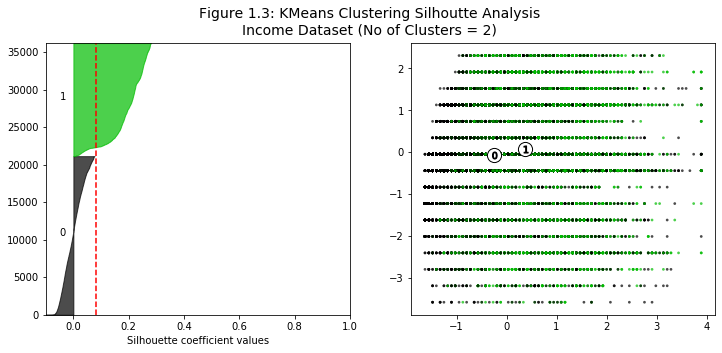

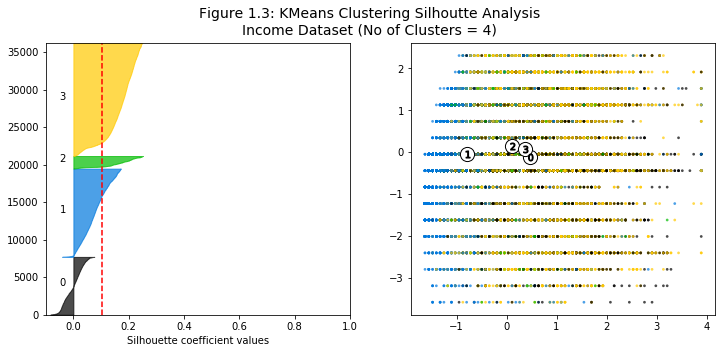

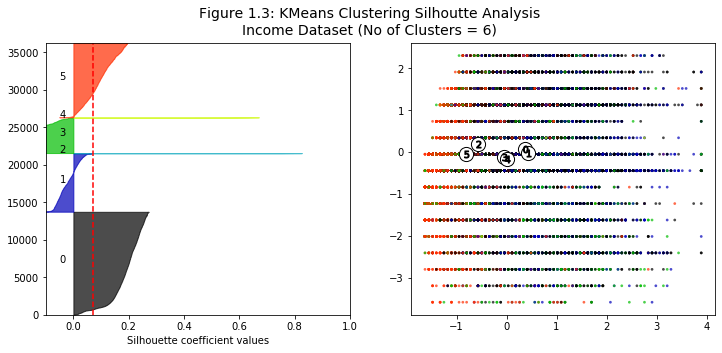

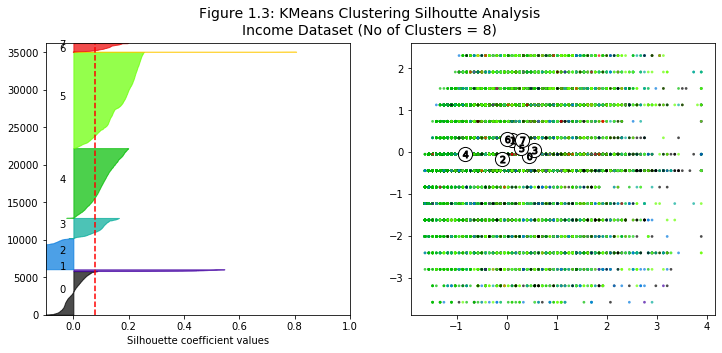

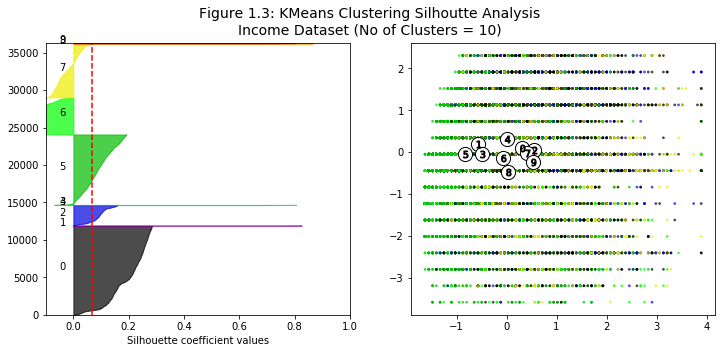

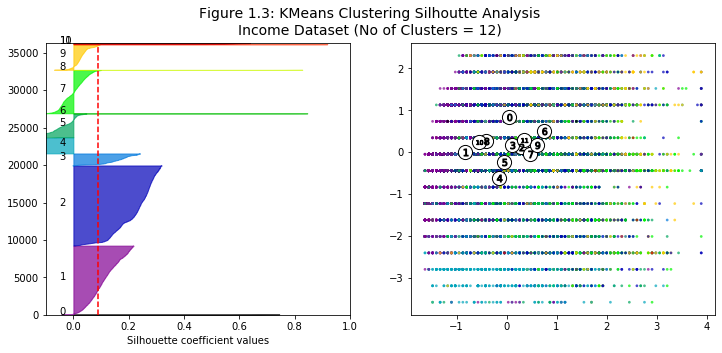

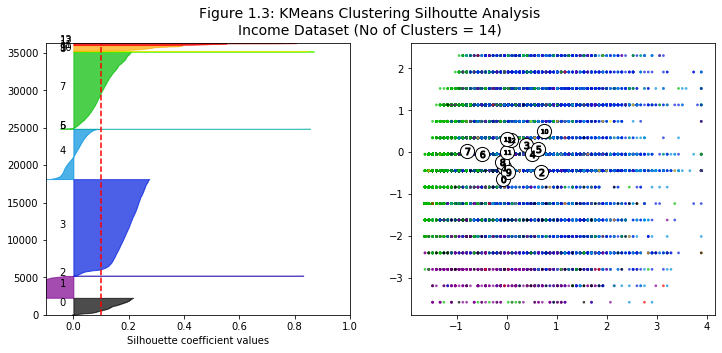

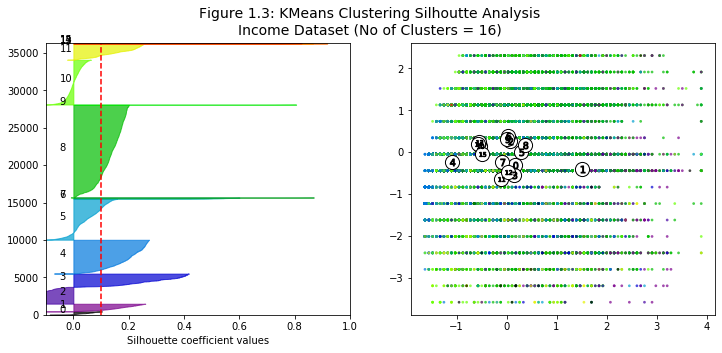

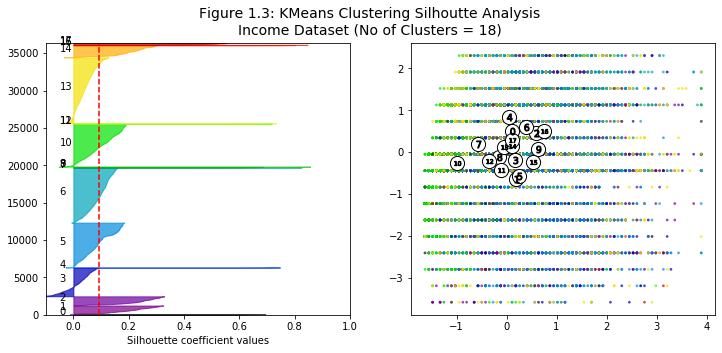

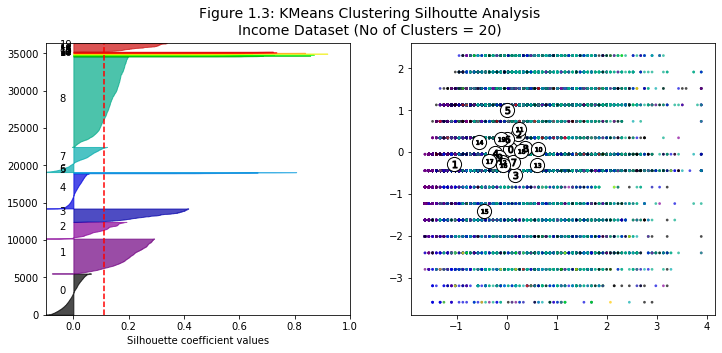

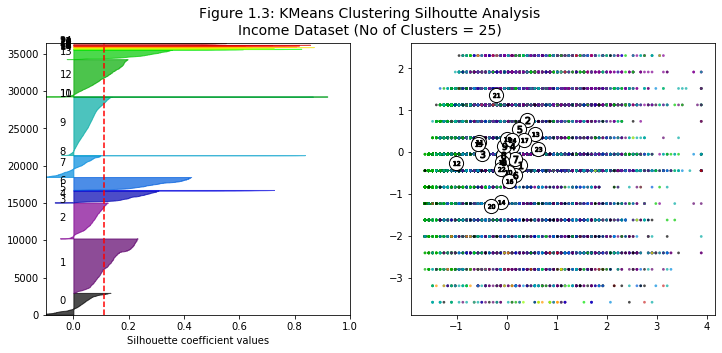

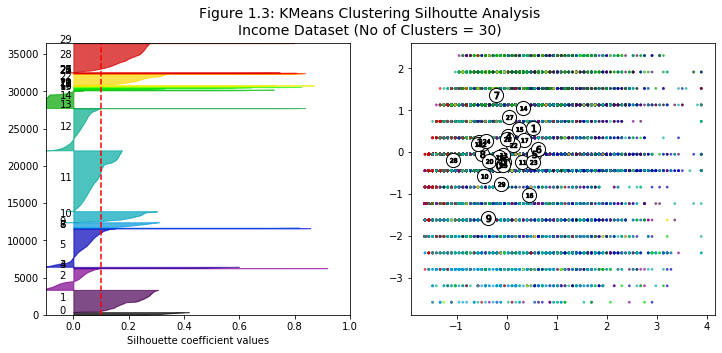

In [8]:
KM_Silhoutte(X_train, Y_train)

In [9]:
def compute_bic_score(X,title1, title2):
    lowest_bic = np.infty
    bic = []
    n_components_range = [2,4,6,8,10,12,14,16,18,20,25,30]
    cv_types = ['spherical', 'tied', 'diag', 'full']
    for cv_type in cv_types:
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = GaussianMixture(n_components=n_components,
                                          covariance_type=cv_type)
            gmm.fit(X)
            bic.append(gmm.bic(X))
            print("CV Type: ", cv_type, " Components: ", n_components, " BIC Score: ", bic[-1])
            if bic[-1] < lowest_bic:
                lowest_bic = bic[-1]
                best_gmm = gmm

    bic = np.array(bic)
    color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue',
                                  'darkorange'])

    print("Lowest BIC score = ", lowest_bic)
    # Plot the BIC scores
    plt.figure(figsize=(8, 6))
    clf = best_gmm
    bars = []
    spl = plt.subplot(2, 1, 1)
    for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
        xpos = np.array(n_components_range) + .2 * (i - 2)
        bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                      (i + 1) * len(n_components_range)],
                            width=.2, color=color))
    plt.xticks(n_components_range)
    plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
    plt.title(title1)
    xpos = np.mod(bic.argmin(), len(n_components_range)) + .65 +\
        .2 * np.floor(bic.argmin() / len(n_components_range))
    plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
    spl.set_xlabel('Number of components')
    spl.legend([b[0] for b in bars], cv_types)
    #plt.show()
    #plt.close()

    # Plot the winner
    #4splot = plt.subplot(2, 1, 2)
    Y_ = clf.predict(X)
    plt.show()
    plt.close()

CV Type:  spherical  Components:  2  BIC Score:  6986357.822452916
CV Type:  spherical  Components:  4  BIC Score:  6434361.585392872
CV Type:  spherical  Components:  6  BIC Score:  6516814.151453002
CV Type:  spherical  Components:  8  BIC Score:  6084228.923079217
CV Type:  spherical  Components:  10  BIC Score:  5762750.719819664
CV Type:  spherical  Components:  12  BIC Score:  5720984.73560336
CV Type:  spherical  Components:  14  BIC Score:  5845278.291031575
CV Type:  spherical  Components:  16  BIC Score:  5814403.920487542
CV Type:  spherical  Components:  18  BIC Score:  5557846.257856089
CV Type:  spherical  Components:  20  BIC Score:  5724045.86817732
CV Type:  spherical  Components:  25  BIC Score:  5533624.2194878
CV Type:  spherical  Components:  30  BIC Score:  4992626.243944958
CV Type:  tied  Components:  2  BIC Score:  4443030.446435416
CV Type:  tied  Components:  4  BIC Score:  4295826.503749669
CV Type:  tied  Components:  6  BIC Score:  4656025.341227304
CV Typ

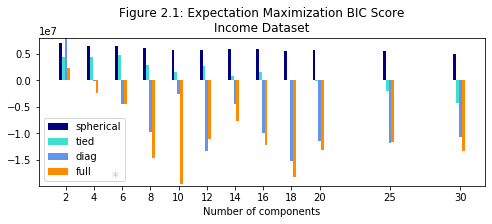

In [10]:
compute_bic_score(X_train, "Figure 2.1: Expectation Maximization BIC Score\nIncome Dataset" , "Figure 2.2: Cluster Representation\nIncome Dataset")

## Part 2: Dimensionality Reduction (PCA, ICA, RP and SVD)

In [24]:
dimensions = range(1, 85)
ann_learning_rate = [0.05]
ann_hidden_layers = [(8)]

def run_ann(dimensions, classifier, X, Y):
    grid ={'clf__n_components':dimensions,'NN__learning_rate_init':ann_learning_rate,'NN__hidden_layer_sizes':ann_hidden_layers}      
    ann = MLPClassifier(activation='logistic',max_iter=2000,early_stopping=True,random_state=5)
    pipe = Pipeline([('clf',classifier),('NN',ann)])
    gs = GridSearchCV(pipe,grid,verbose=2,cv=5)
    gs.fit(X, Y)
    return (pd.DataFrame(gs.cv_results_) , gs.best_estimator_)

In [25]:
print('Part 2: PCA for Income dataset')
pca = PCA(random_state = 5)
pca.fit_transform(X_train)
EVR = pd.Series(data = pca.explained_variance_ratio_,index = range(0,85))
EVR.to_csv('./P2/IncomePCA-EVR.csv')
EV = pd.Series(data = pca.explained_variance_,index = range(0,85))
EV.to_csv('./P2/IncomePCA-EV.csv')
pca = PCA(random_state = 5)  
nn_results, clf = run_ann(dimensions, pca, X_train, Y_train)     
nn_results.to_csv('./P2/IncomePCA_ANN.csv')
test_score = clf.score(X_test, Y_test)

Part 2: PCA for Income dataset
Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   0.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   0.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   0.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   1.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   1.6s
[CV] NN__hidden_lay

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=10, total=   0.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=10, total=   1.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11, total=   1.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11, total=   1.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11, total=   1.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11, total=   1.4s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=19, total=   1.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   1.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   1.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   1.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   1.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   1.2s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   1.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   1.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   1.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   1.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   1.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=30, total=   1.7s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38, total=   2.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38, total=   1.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38, total=   2.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38, total=   1.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=39 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=39, total=   1.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=39 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=39, total=   1.1s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47, total=   1.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47, total=   1.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47, total=   2.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48, total=   2.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48, total=   1.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48, total=   1.3s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=56, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=56 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=56, total=   1.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57, total=   1.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57, total=   2.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57, total=   3.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57, total=   2.5s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=65, total=   1.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   1.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   1.7s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   1.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   2.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   1.5s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   1.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   1.7s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   1.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   1.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   1.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=76 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=76, total=   1.8s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84, total=   1.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84, total=   1.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84, total=   2.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84, total=   1.7s


[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 10.6min finished


Test Accuracy  :  0.8308457711442786
Best Estimator :  Pipeline(memory=None,
         steps=[('clf',
                 PCA(copy=True, iterated_power='auto', n_components=43,
                     random_state=5, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('NN',
                 MLPClassifier(activation='logistic', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=True, epsilon=1e-08,
                               hidden_layer_sizes=8, learning_rate='constant',
                               learning_rate_init=0.05, max_iter=2000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=5, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                               verbose=False, warm_start=False

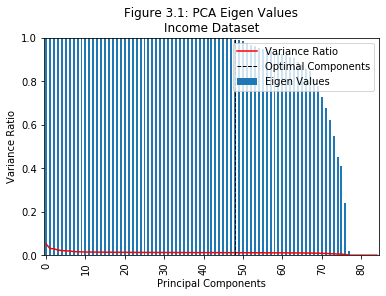

Reduced Dimension: 82 out of 85
Variance captured: 11.169802345352783 %


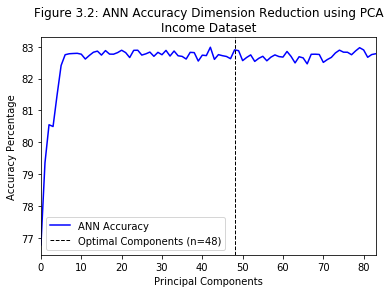

In [26]:
EVR.plot( ylim = (0.,0.35), color = 'red',  label = "Variance Ratio" )

ax = EV.plot(kind = 'bar',ylim = (0.,1.0),label = "Eigen Values")

ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::10])
ax.xaxis.set_ticklabels(ticklabels[::10]);
ax.axvline(x = 48 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components")

plt.legend(loc=1)
plt.title("Figure 3.1: PCA Eigen Values\nIncome Dataset")
plt.xlabel("Principal Components")
plt.ylabel("Variance Ratio");
plt.show()
plt.close()

print("Reduced Dimension: {} out of {}".
      format(X_train.shape[1]-len([i for i in EVR if i >= 0.025]),X_train.shape[1]))
print("Variance captured: {} %".format(sum([i for i in EVR if i >= 0.025])*100.))

nn_pca = pd.read_csv("./P2/IncomePCA_ANN.csv", header = 'infer')
nn_pca = nn_results['mean_test_score'] * 100.0

nn_pca.plot( color = 'blue',  label = "ANN Accuracy" )
plt.axvline(x = 48 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=48)")

plt.legend(loc='best')
plt.title("Figure 3.2: ANN Accuracy Dimension Reduction using PCA\nIncome Dataset")
plt.xlabel("Principal Components")
plt.ylabel("Accuracy Percentage");
plt.show()
plt.close()


In [27]:
ica = FastICA(random_state=5)
temp = ica.fit_transform(X_train)
order = [-abs(kurtosis(temp[:,i])) for i in range(temp.shape[1])]
temp = temp[:,np.array(order).argsort()]
kurt =  pd.Series([abs(kurtosis(temp[:,i])) for i in range(temp.shape[1])]);

ica = FastICA(random_state=5)  
nn_results , clf = run_ann(dimensions, ica, X_train, Y_train)     
nn_results.to_csv('./P2/IncomeICA_ANN.csv')
test_score = clf.score(X_test, Y_test)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   2.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=1, total=   1.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   1.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=2, total=   1.1s
[CV] NN__hidden_lay

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=10, total=   1.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=10 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=10, total=   1.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11, total=   1.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11, total=   1.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11, total=   1.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=11, total=   1.1s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=19, total=   1.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   2.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   1.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   1.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   1.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=20, total=   1.2s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   2.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   2.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   1.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   2.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=29, total=   1.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=30 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=30, total=   2.0s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38, total=   1.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38, total=   2.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38, total=   2.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=38, total=   1.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=39 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=39, total=   2.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=39 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=39, total=   2.0s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47, total=   2.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=47, total=   2.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48, total=   3.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48, total=   2.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=48, total=   2.0s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=56, total=   3.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=56 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=56, total=   3.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57, total=   2.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57, total=   2.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=57, total=   4.7s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=65, total=   3.7s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   4.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   3.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=66, total=   3.4s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   3.7s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   4.7s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   4.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   4.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=75, total=   4.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=76 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=76, total=   4.1s
[CV] NN_

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84, total=   8.7s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84, total=   8.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84, total=   8.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, clf__n_components=84, total=   8.3s


[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 20.2min finished


Test Accuracy  :  0.8323935876174682
Best Estimator :  Pipeline(memory=None,
         steps=[('clf',
                 FastICA(algorithm='parallel', fun='logcosh', fun_args=None,
                         max_iter=200, n_components=81, random_state=5,
                         tol=0.0001, w_init=None, whiten=True)),
                ('NN',
                 MLPClassifier(activation='logistic', alpha=0.0001,
                               batch_size='auto', beta_1=0.9, beta_2=0.999,
                               early_stopping=True, epsilon=1e-08,
                               hidden_layer_sizes=8, learning_rate='constant',
                               learning_rate_init=0.05, max_iter=2000,
                               momentum=0.9, n_iter_no_change=10,
                               nesterovs_momentum=True, power_t=0.5,
                               random_state=5, shuffle=True, solver='adam',
                               tol=0.0001, validation_fraction=0.1,
                      

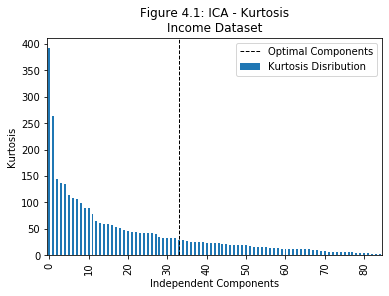

Reduced Dimension: 15 out of 85


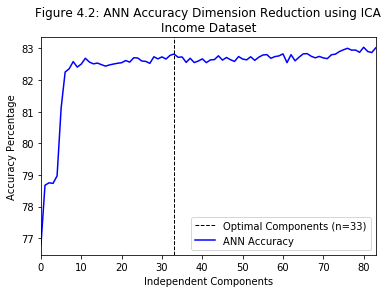

In [28]:
plt.figure(figsize=(6,4))
ax = kurt.plot(kind = 'bar', label = "Kurtosis Disribution");
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::10])
ax.xaxis.set_ticklabels(ticklabels[::10]);
ax.axvline(x=33 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components")


plt.legend(loc='best')
plt.title("Figure 4.1: ICA - Kurtosis\nIncome Dataset")
plt.xlabel("Independent Components")
plt.ylabel("Kurtosis");
plt.show()
plt.close()
print("Reduced Dimension: {} out of {}".format(X_train.shape[1]-len([i for i in kurt if i >= 8.]),
                                               X_train.shape[1]))
nn_ica = pd.read_csv("./P2/IncomeICA_ANN.csv", header = 'infer')
nn_ica = nn_results['mean_test_score'] * 100.0
plt.axvline(x=33 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=33)")
nn_ica.plot( color = 'blue',  label = "ANN Accuracy" )
plt.legend(loc='best')
plt.title("Figure 4.2: ANN Accuracy Dimension Reduction using ICA\nIncome Dataset")
plt.xlabel("Independent Components")
plt.ylabel("Accuracy Percentage");
plt.show()
plt.close()

In [ ]:
def distance_correlation (X1,X2):
    assert X1.shape[0] == X2.shape[0]
    return np.corrcoef(pairwise_distances(X1).ravel(),pairwise_distances(X2).ravel())[0,1]

In [ ]:
tmp = defaultdict(dict)
for i,dim in product(range(10),dimensions):
    rp = SparseRandomProjection(random_state=i, n_components=dim)
    tmp[dim][i] = distance_correlation(rp.fit_transform(X_train), X_train)

tmp = pd.DataFrame(tmp).T
tmp.to_csv('./P2/IncomeRP_DistanceCorrelation.csv')

In [ ]:
# Run Neural Networks
rp = SparseRandomProjection(random_state=5) 
nn_results, clf = run_ann(dimensions, rp,  X_train, Y_train)     
nn_results.to_csv('./P2/IncomeRP_ANN.csv')

## test score
test_score = clf.score(X_test, Y_test)
print("Test Accuracy = ", test_score )
print("Best Estimator = ", clf)

In [ ]:
tmp['mean'] = tmp.mean(axis=1)

distance = tmp['mean']*100.0

distance.plot(color = 'blue',  label = "Distance Correlation" )
plt.axvline(x=8 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features")

plt.legend(loc='best')
plt.title("Figure 5.1: Random Projection Distance Correlation\nIncome Dataset")
plt.xlabel("Random Components")
plt.ylabel("Distance Correlation");
plt.show()
plt.close()

nn_results = pd.read_csv("./P2/IncomeRP_ANN.csv", header = 'infer')
nn_results = nn_results['mean_test_score'] * 100.0
nn_results.plot( color = 'blue',  label = "Accuracy Percentage" )
plt.axvline(x=8 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features (n=8)")

plt.legend(loc='best')
plt.title("Figure 5.2: ANN Accuracy Dimension Reduction using RP\nIncome Dataset")
plt.xlabel("Random Components")
plt.ylabel("Accuracy Percentage");
plt.show()
plt.close()

In [16]:
class ImportanceSelect(BaseEstimator, TransformerMixin):
    def __init__(self, model, n=1):
         self.model = model
         self.n = n
    def fit(self, *args, **kwargs):
         self.model.fit(*args, **kwargs)
         return self
    def transform(self, X):
         return X[:,self.model.feature_importances_.argsort()[::-1][:self.n]]


In [17]:
rfc = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=5, n_jobs=-1)
result = rfc.fit(X_train, Y_train).feature_importances_ 
tmp = pd.Series(np.sort(result)[::-1])
tmp.to_csv('./P2/IncomeRF_FI.csv')

In [18]:
ann_learning_rate = [0.05]
ann_hidden_layers = [(8)]

rfc = RandomForestClassifier(n_estimators=100,class_weight='balanced',random_state=5,n_jobs=-1)
filtr = ImportanceSelect(rfc)
grid ={'filter__n':dimensions,'NN__learning_rate_init':ann_learning_rate,'NN__hidden_layer_sizes':ann_hidden_layers}  
ann = MLPClassifier(activation='logistic',max_iter=2000,early_stopping=True,random_state=5)
pipe = Pipeline([('filter',filtr),('NN',ann)])
gs = GridSearchCV(pipe,grid,verbose=10,cv=5)
gs.fit(X_train, Y_train)
nn_results = pd.DataFrame(gs.cv_results_)
nn_results.to_csv('./P2/IncomeRF_ANN.csv')

Fitting 5 folds for each of 84 candidates, totalling 420 fits
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1, score=0.752, total=   4.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.7s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1, score=0.752, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1, score=0.752, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.3s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1, score=0.752, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   14.6s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=1, score=0.752, total=   3.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   17.7s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2, score=0.788, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2 


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   20.9s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2, score=0.777, total=   3.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2 


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   24.4s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2, score=0.779, total=   3.7s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2 


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   28.1s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2, score=0.787, total=   3.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   31.6s remaining:    0.0s


[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=2, score=0.788, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3, score=0.795, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3, score=0.789, total=   3.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3, score=0.785, total=   3.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3, score=0.791, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=3, score=0.798, total=   3.0s
[CV] NN__hidden_layer_sizes=8

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=12, score=0.826, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=12 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=12, score=0.825, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=12 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=12, score=0.820, total=   4.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=12 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=12, score=0.835, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=13 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=13, score=0.831, total=   3.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=13 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=13, score=0.827, total=   3.9s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=21, score=0.829, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=21 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=21, score=0.836, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=22 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=22, score=0.830, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=22 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=22, score=0.827, total=   3.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=22 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=22, score=0.829, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=22 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=22, score=0.829, total=   3.6s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=31, score=0.832, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=31 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=31, score=0.825, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=31 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=31, score=0.831, total=   4.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=31 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=31, score=0.825, total=   3.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=31 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=31, score=0.838, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=32 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=32, score=0.832, total=   3.3s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=40, score=0.831, total=   4.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=40 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=40, score=0.824, total=   3.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=40 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=40, score=0.831, total=   4.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=41 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=41, score=0.830, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=41 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=41, score=0.827, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=41 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=41, score=0.833, total=   3.4s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=49, score=0.834, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50, score=0.831, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50, score=0.822, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50, score=0.830, total=   3.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50, score=0.830, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=50, score=0.834, total=   3.2s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=59, score=0.823, total=   3.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=59 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=59, score=0.831, total=   3.4s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=59 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=59, score=0.829, total=   3.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=59 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=59, score=0.834, total=   3.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=60 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=60, score=0.827, total=   4.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=60 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=60, score=0.826, total=   3.4s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=68, score=0.822, total=   3.3s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=68 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=68, score=0.835, total=   3.8s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=69 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=69, score=0.831, total=   3.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=69 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=69, score=0.825, total=   3.5s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=69 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=69, score=0.827, total=   3.2s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=69 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=69, score=0.826, total=   3.4s
[CV] NN__hidden_la

[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=78, score=0.828, total=   3.9s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=78 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=78, score=0.824, total=   4.1s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=78 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=78, score=0.833, total=   3.6s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=78 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=78, score=0.828, total=   4.7s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=78 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=78, score=0.832, total=   4.0s
[CV] NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=79 
[CV]  NN__hidden_layer_sizes=8, NN__learning_rate_init=0.05, filter__n=79, score=0.828, total=   4.2s
[CV] NN__hidden_la

[Parallel(n_jobs=1)]: Done 420 out of 420 | elapsed: 25.0min finished


<Figure size 864x576 with 0 Axes>

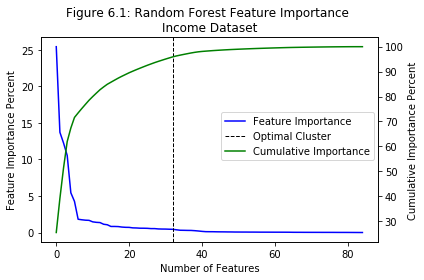

In [19]:
df1 = pd.read_csv("./P2/IncomeRF_FI.csv", header=None)
x_data = df1[0] 

plt.figure(figsize = (12,8))
fig, ax1 = plt.subplots()
ax1.plot(x_data, df1[1]* 100.0, label = "Feature Importance" , color = "blue",)
ax1.axvline(x=32 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Cluster")
ax2 = ax1.twinx() 
ax2.plot(x_data, df1[2]*100.0, label = "Cumulative Importance" , color = "green",)
fig.legend(loc='center left', bbox_to_anchor=(0.5, 0.5))
plt.title("Figure 6.1: Random Forest Feature Importance \nIncome Dataset")
ax1.set_xlabel("Number of Features")
ax1.set_ylabel("Feature Importance Percent")
ax2.set_ylabel("Cumulative Importance Percent")
fig.tight_layout() 

plt.show()
plt.close()

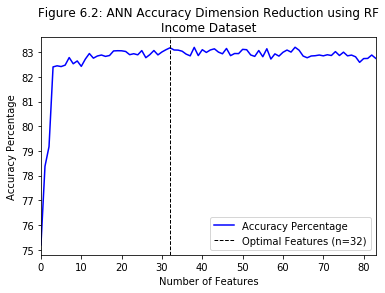

In [20]:
nn_results = pd.read_csv("./P2/IncomeRF_ANN.csv", header = 'infer')
nn_results = nn_results['mean_test_score'] * 100.0
#nn_train_results_pca = nn_results['mean_train_score'] * 100.0
nn_results.plot( color = 'blue',  label = "Accuracy Percentage" )
plt.axvline(x=32 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Features (n=32)")

plt.legend(loc='best')
plt.title("Figure 6.2: ANN Accuracy Dimension Reduction using RF\nIncome Dataset")
plt.xlabel("Number of Features")
plt.ylabel("Accuracy Percentage");
plt.show()
plt.close()

clf = gs.best_estimator_
test_score = clf.score(X_test, Y_test)


## Part 3: Clustering after reducing dimensions

In [21]:
dimensions_PCA = 48 
dimensions_ICA = 33 
dimensions_RP = 32 
dimensions_RF = 32

rfc = RandomForestClassifier(n_estimators = 100, class_weight = 'balanced', random_state =5, n_jobs = -1)

algo_name = ['PCA', 'ICA', 'RP', 'RF']

filter_ = ImportanceSelect(rfc,dimensions_RF)

algos = [PCA(n_components=dimensions_PCA,random_state=10), 
           FastICA(n_components=dimensions_ICA,random_state=10), 
           SparseRandomProjection(n_components=dimensions_RP,random_state=5),
           ImportanceSelect(rfc,dimensions_RF)]

for i in range(len(algos)):
    if i == 3:
        X2 = algos[i].fit_transform(X_train, Y_train)
    else:   
        X2 = algos[i].fit_transform(X_train)
    data2 = pd.DataFrame(np.hstack((X2,np.atleast_2d(Y_train).T)))
    cols = list(range(data2.shape[1]))
    cols[-1] = 'Class'
    data2.columns = cols
    data2.to_hdf('datasets.hdf','Income_'+algo_name[i],complib='blosc',complevel=9)

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32,      33,      34,      35,      36,      37,      38,      39,
            40,      41,      42,      43,      44,      45,      46,      47,
       'Class'],
      dtype='object')
For n_clusters = 2 The average silhouette_score is : 0.8215261357021424
For n_clusters = 4 The average silhouette_score is : 0.3785589217345143
For n_clusters = 6 The average silhouette_score is : 0.048072447009243395
For n_clusters = 8 The average silhouette_score is : 0.04530633324794434
For n_clusters = 10 The average silhouette_score is : 0.08734565667552743
For n_clusters = 12 The average silhouette_score is : 0.09957017541125186
For n_clusters = 14 The average silhouette_score

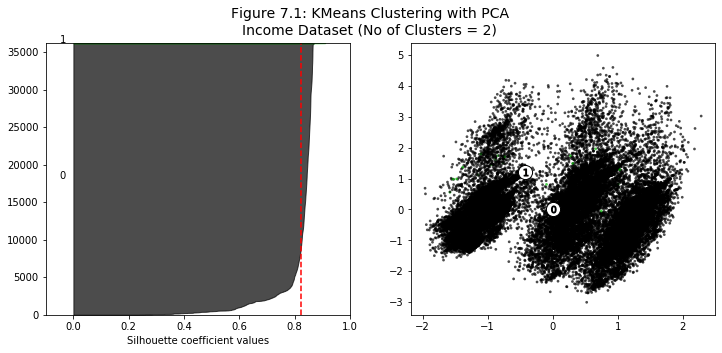

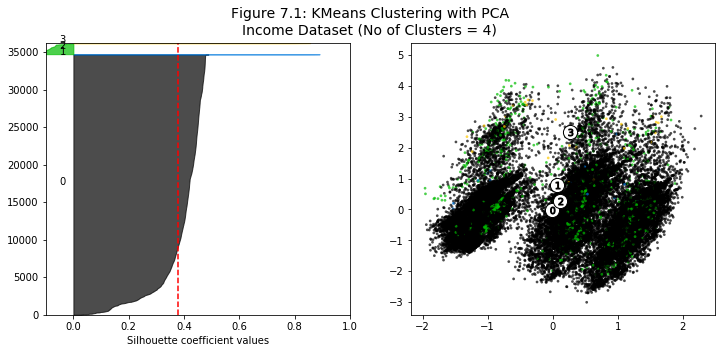

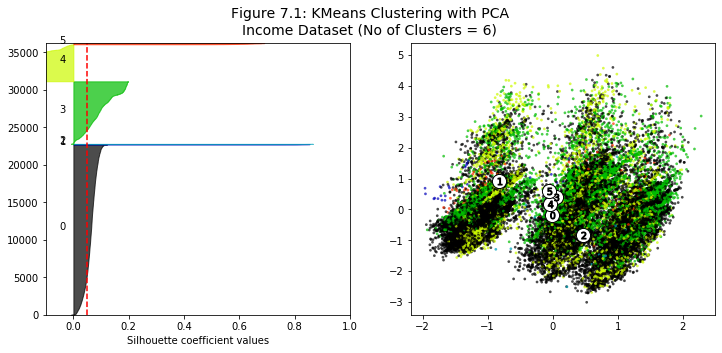

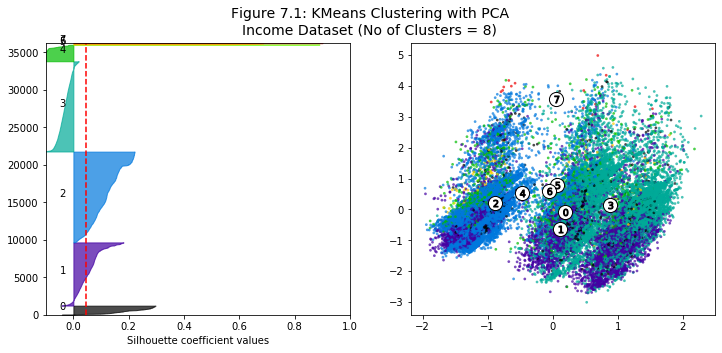

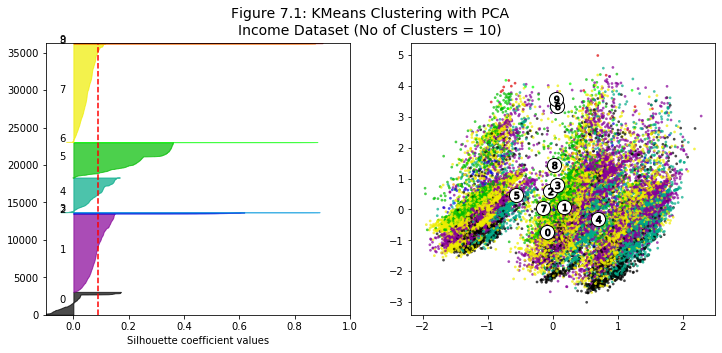

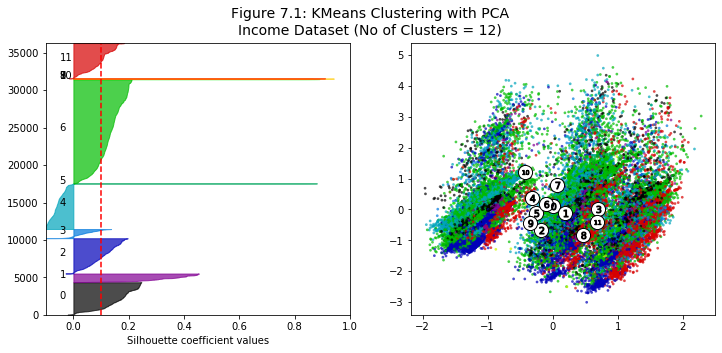

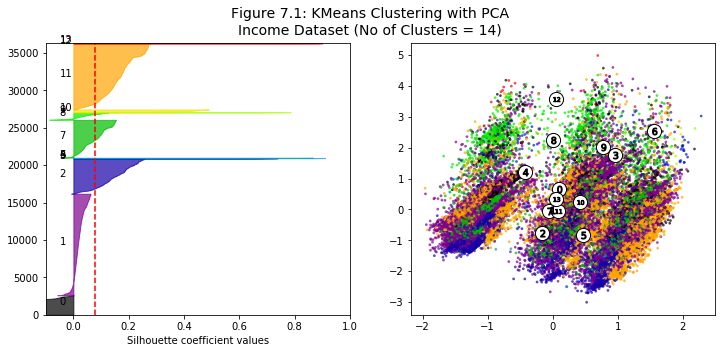

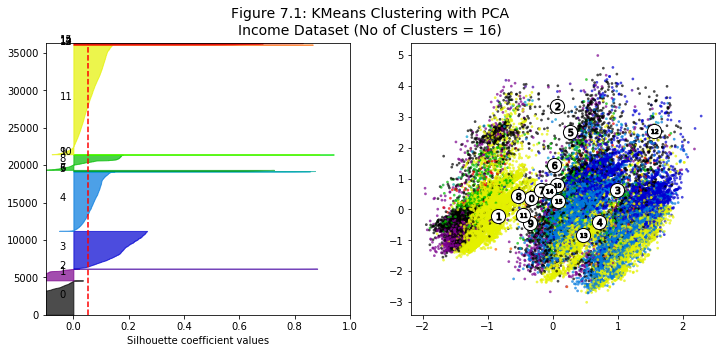

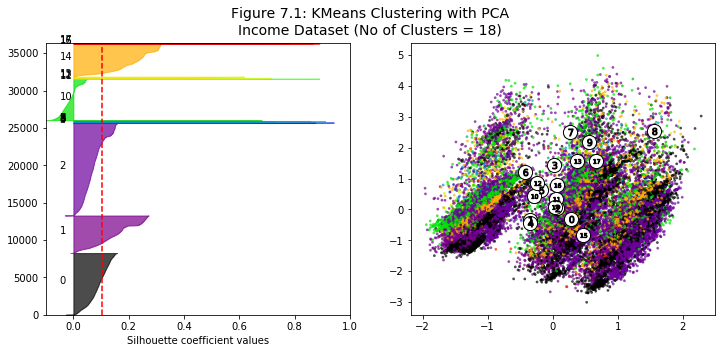

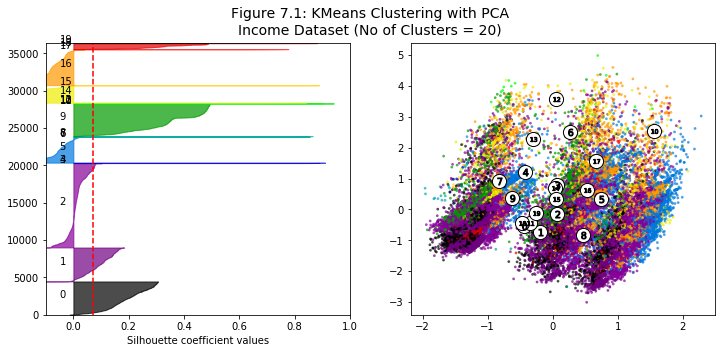

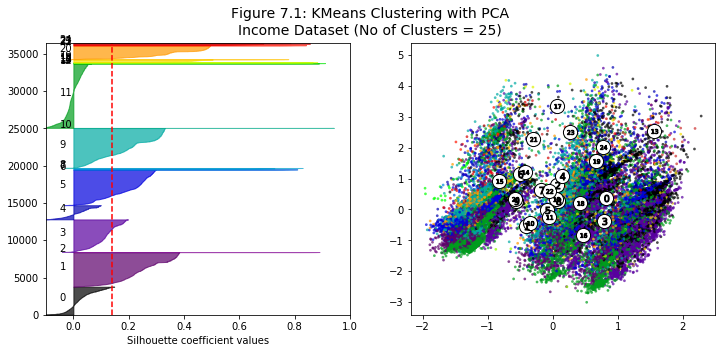

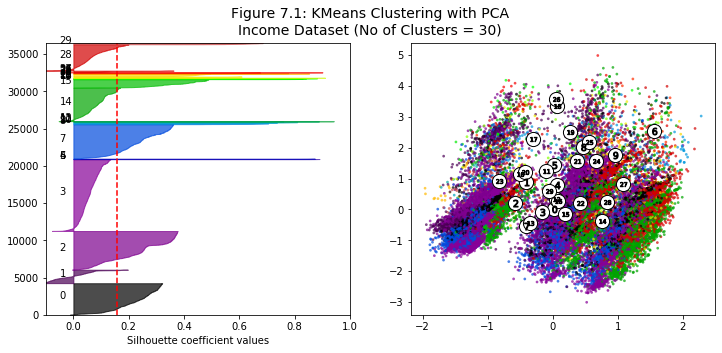

CV Type:  spherical  Components:  2  BIC Score:  3745347.508970262
CV Type:  spherical  Components:  4  BIC Score:  3532961.195789733
CV Type:  spherical  Components:  6  BIC Score:  3360142.199403949
CV Type:  spherical  Components:  8  BIC Score:  3081774.0951205264
CV Type:  spherical  Components:  10  BIC Score:  3123888.0092643755
CV Type:  spherical  Components:  12  BIC Score:  2869741.422831554
CV Type:  spherical  Components:  14  BIC Score:  3071478.101352785
CV Type:  spherical  Components:  16  BIC Score:  2853588.3174100206
CV Type:  spherical  Components:  18  BIC Score:  2615582.9497430166
CV Type:  spherical  Components:  20  BIC Score:  2687781.8136283876
CV Type:  spherical  Components:  25  BIC Score:  2470931.75167062
CV Type:  spherical  Components:  30  BIC Score:  2697144.886425882
CV Type:  tied  Components:  2  BIC Score:  4840880.209987787
CV Type:  tied  Components:  4  BIC Score:  4797182.67070697
CV Type:  tied  Components:  6  BIC Score:  4773559.587339994

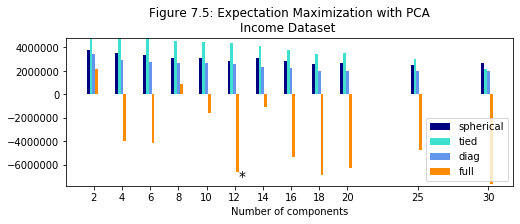

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
            32, 'Class'],
      dtype='object')
For n_clusters = 2 The average silhouette_score is : 0.9646678522672069
For n_clusters = 4 The average silhouette_score is : 0.07592079643340581
For n_clusters = 6 The average silhouette_score is : 0.213497825645132
For n_clusters = 8 The average silhouette_score is : 0.072037914310071
For n_clusters = 10 The average silhouette_score is : 0.09107576272590284
For n_clusters = 12 The average silhouette_score is : 0.11480603385717252
For n_clusters = 14 The average silhouette_score is : 0.08893000622045108
For n_clusters = 16 The average silhouette_score is : 0.09890706000954294
For n_clusters = 18 The average silhouette_score is :

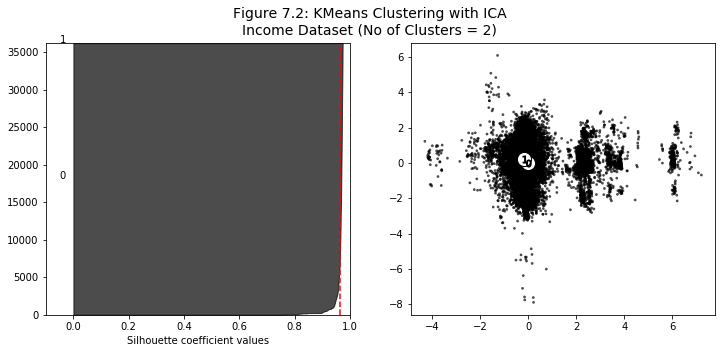

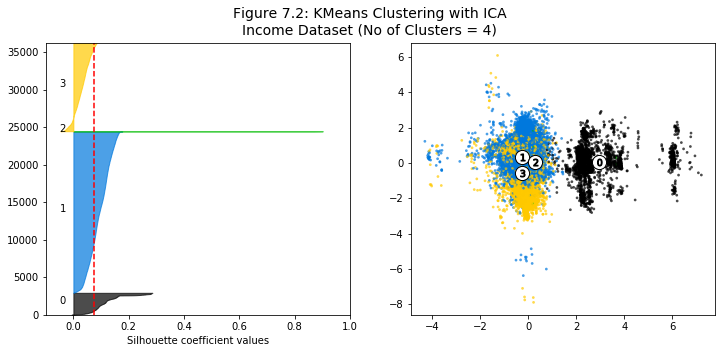

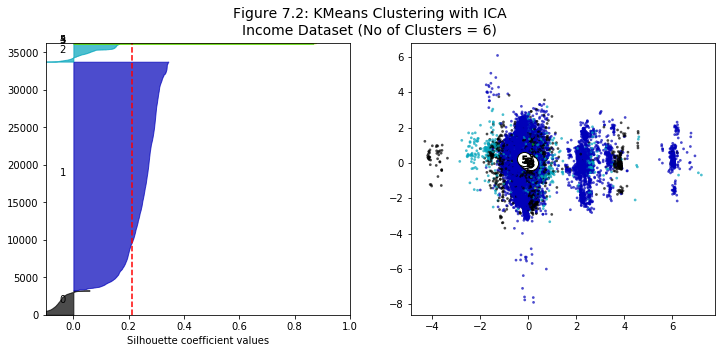

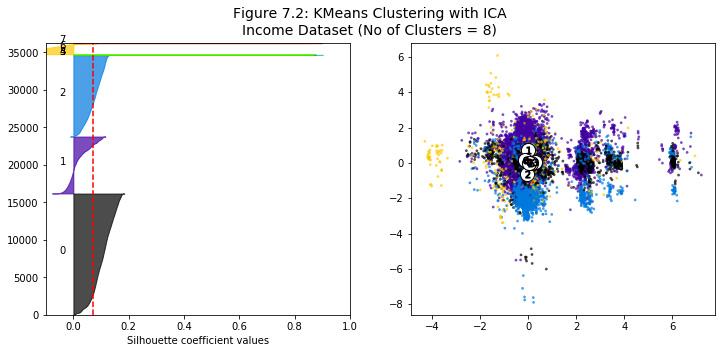

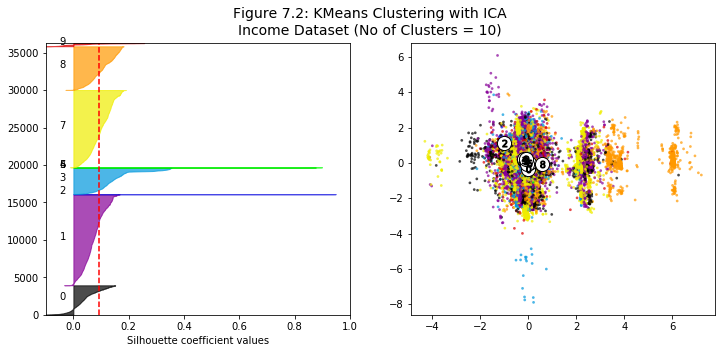

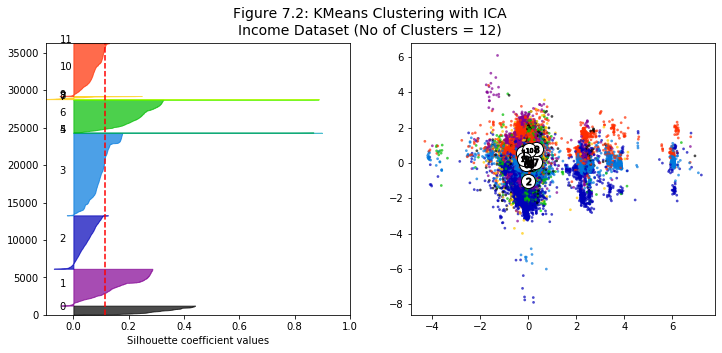

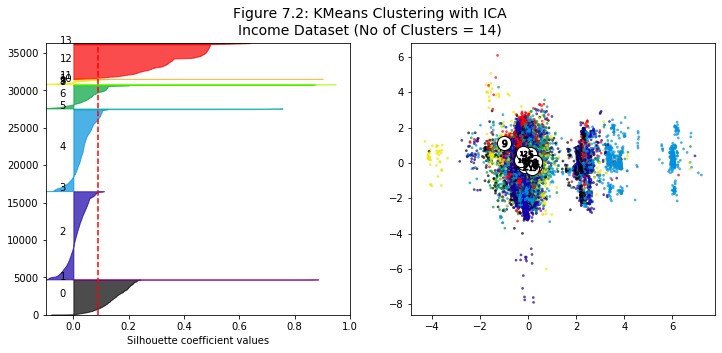

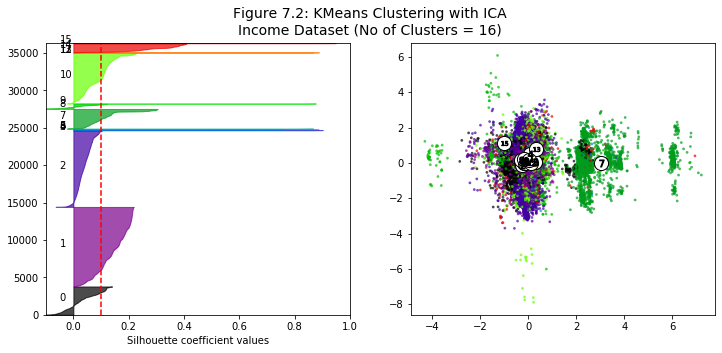

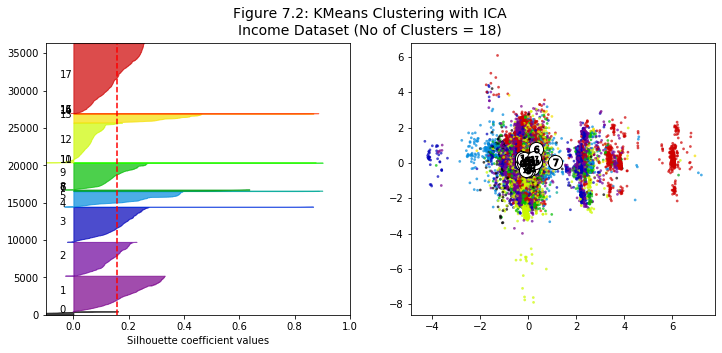

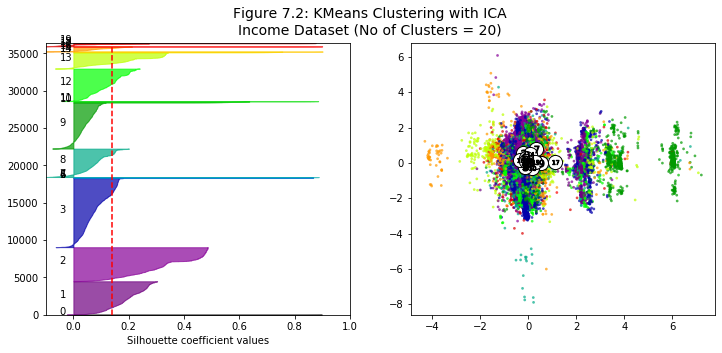

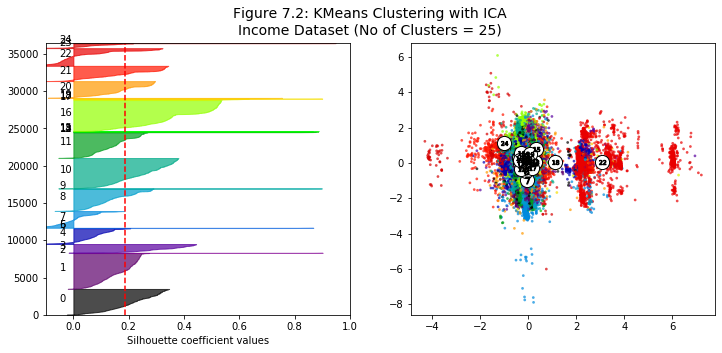

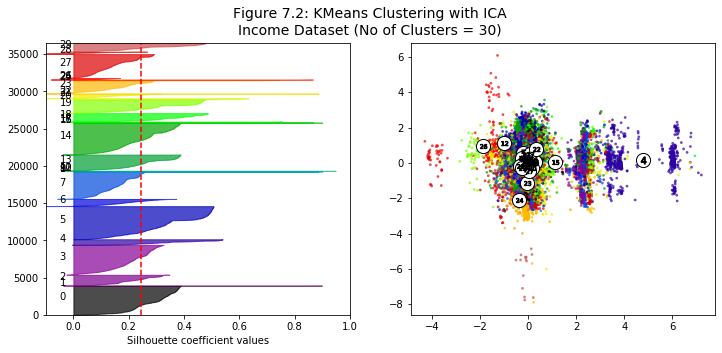

CV Type:  spherical  Components:  2  BIC Score:  2794893.5705766655
CV Type:  spherical  Components:  4  BIC Score:  2666504.704999755
CV Type:  spherical  Components:  6  BIC Score:  2505135.568666979
CV Type:  spherical  Components:  8  BIC Score:  2433314.9162478237
CV Type:  spherical  Components:  10  BIC Score:  2477678.9921725243
CV Type:  spherical  Components:  12  BIC Score:  2449741.55101997
CV Type:  spherical  Components:  14  BIC Score:  2191846.4963730136
CV Type:  spherical  Components:  16  BIC Score:  2111020.322212734
CV Type:  spherical  Components:  18  BIC Score:  2209041.0056039
CV Type:  spherical  Components:  20  BIC Score:  2032230.648118387
CV Type:  spherical  Components:  25  BIC Score:  1788065.267311982
CV Type:  spherical  Components:  30  BIC Score:  1783151.3680130304
CV Type:  tied  Components:  2  BIC Score:  3355552.7944893087
CV Type:  tied  Components:  4  BIC Score:  3315336.9927786887
CV Type:  tied  Components:  6  BIC Score:  2955079.49826890

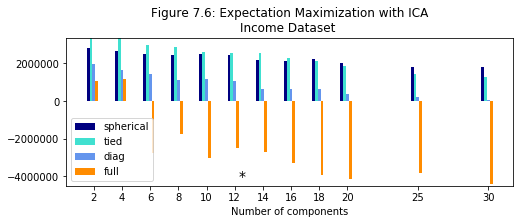

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
       'Class'],
      dtype='object')
For n_clusters = 2 The average silhouette_score is : 0.16022875673042225
For n_clusters = 4 The average silhouette_score is : 0.15969012342995884
For n_clusters = 6 The average silhouette_score is : 0.15536780189221971
For n_clusters = 8 The average silhouette_score is : 0.09753844411831471
For n_clusters = 10 The average silhouette_score is : 0.0952952534361466
For n_clusters = 12 The average silhouette_score is : 0.10272294301390972
For n_clusters = 14 The average silhouette_score is : 0.10893886515134017
For n_clusters = 16 The average silhouette_score is : 0.09367900790452478
For n_clusters = 18 The average silhouette_score is : 0.12

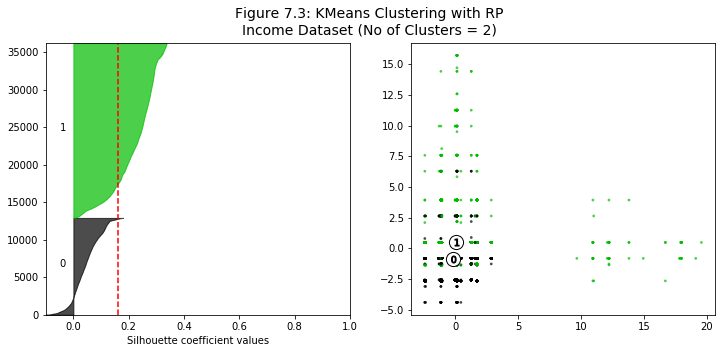

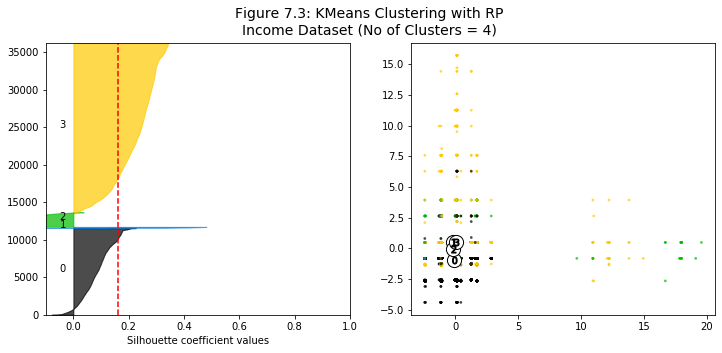

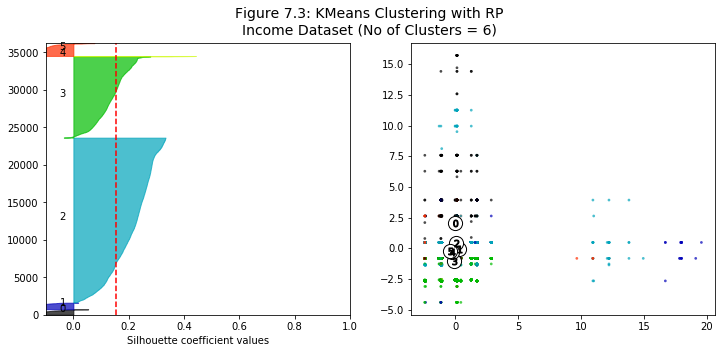

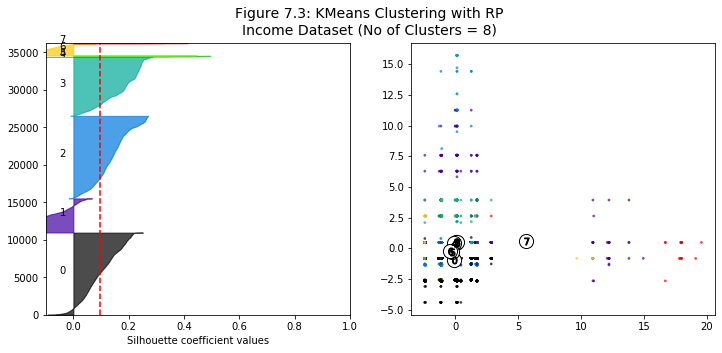

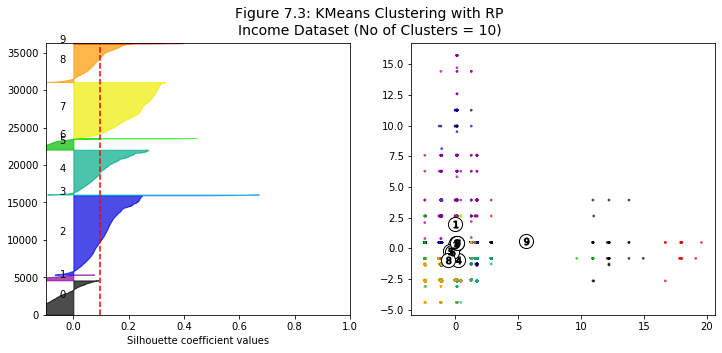

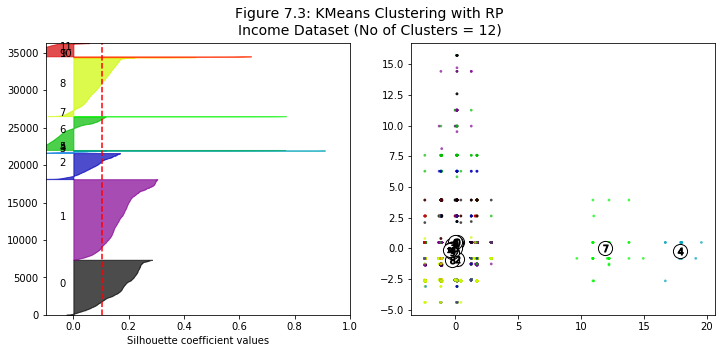

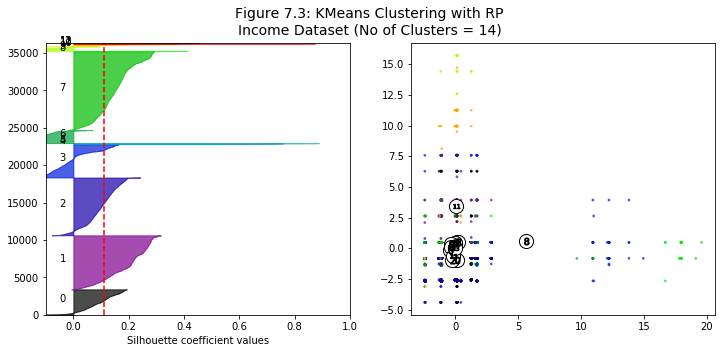

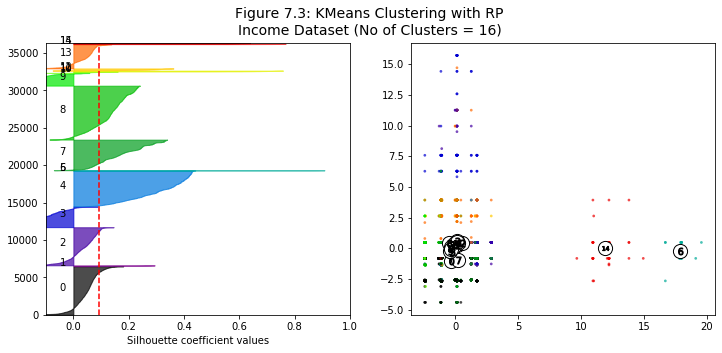

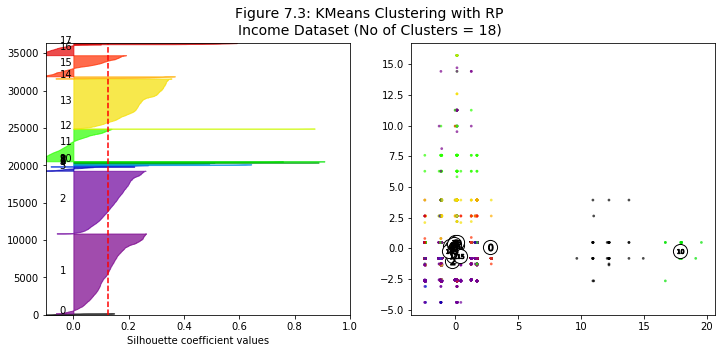

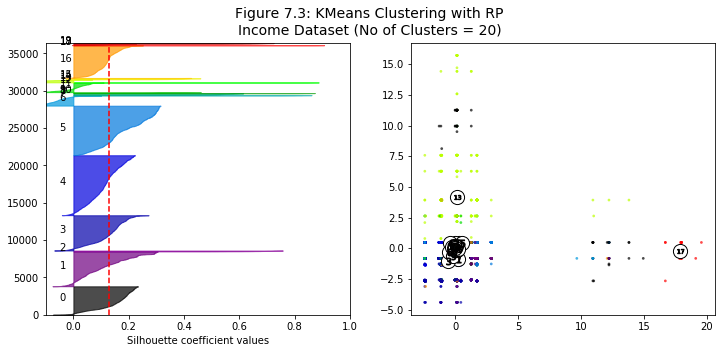

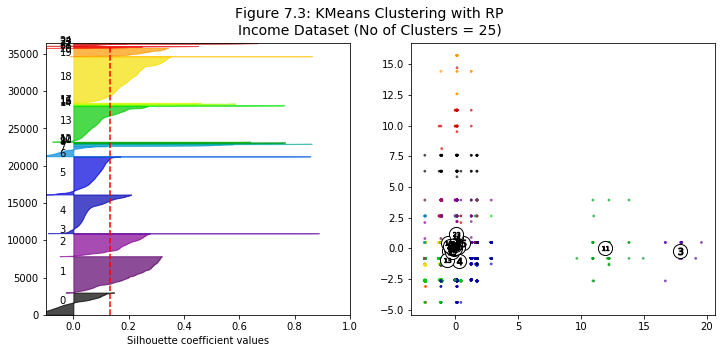

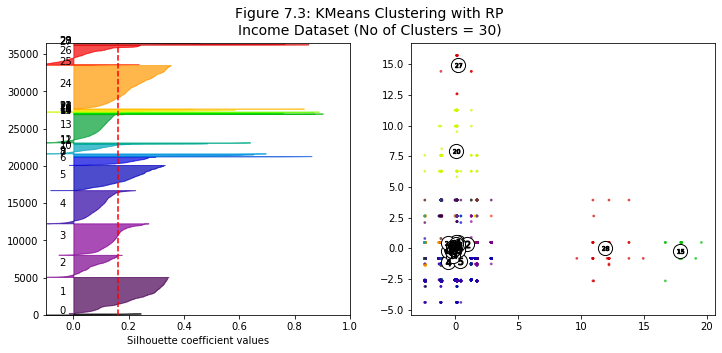

CV Type:  spherical  Components:  2  BIC Score:  2469005.22954279
CV Type:  spherical  Components:  4  BIC Score:  2210724.047029868
CV Type:  spherical  Components:  6  BIC Score:  2124578.46914328
CV Type:  spherical  Components:  8  BIC Score:  1990241.9800328682
CV Type:  spherical  Components:  10  BIC Score:  2026840.3656783383
CV Type:  spherical  Components:  12  BIC Score:  1915772.7693289593
CV Type:  spherical  Components:  14  BIC Score:  1842523.769251369
CV Type:  spherical  Components:  16  BIC Score:  1805533.5327718926
CV Type:  spherical  Components:  18  BIC Score:  1816137.4260121973
CV Type:  spherical  Components:  20  BIC Score:  1732167.9627771338
CV Type:  spherical  Components:  25  BIC Score:  1767862.1836157956
CV Type:  spherical  Components:  30  BIC Score:  1580775.6728847506
CV Type:  tied  Components:  2  BIC Score:  2923609.346985227
CV Type:  tied  Components:  4  BIC Score:  2885791.2198778247
CV Type:  tied  Components:  6  BIC Score:  2819918.75577

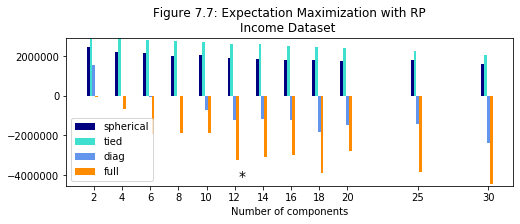

Index([      0,       1,       2,       3,       4,       5,       6,       7,
             8,       9,      10,      11,      12,      13,      14,      15,
            16,      17,      18,      19,      20,      21,      22,      23,
            24,      25,      26,      27,      28,      29,      30,      31,
       'Class'],
      dtype='object')
For n_clusters = 2 The average silhouette_score is : 0.12169582291600911
For n_clusters = 4 The average silhouette_score is : 0.14022899111373643
For n_clusters = 6 The average silhouette_score is : 0.15746669528328971
For n_clusters = 8 The average silhouette_score is : 0.1805351940015467
For n_clusters = 10 The average silhouette_score is : 0.14735435240340997
For n_clusters = 12 The average silhouette_score is : 0.15222477543125723
For n_clusters = 14 The average silhouette_score is : 0.1484213859648749
For n_clusters = 16 The average silhouette_score is : 0.18957531078729173
For n_clusters = 18 The average silhouette_score is : 0.178

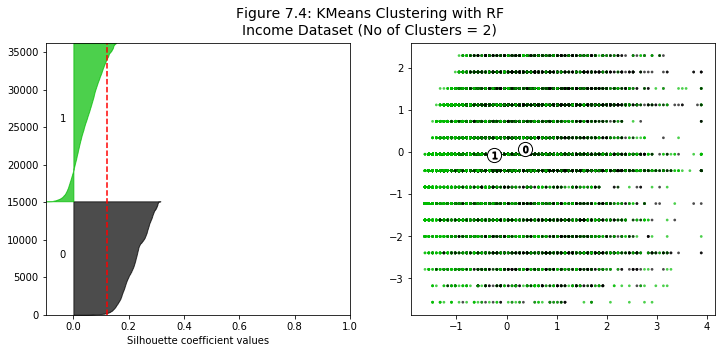

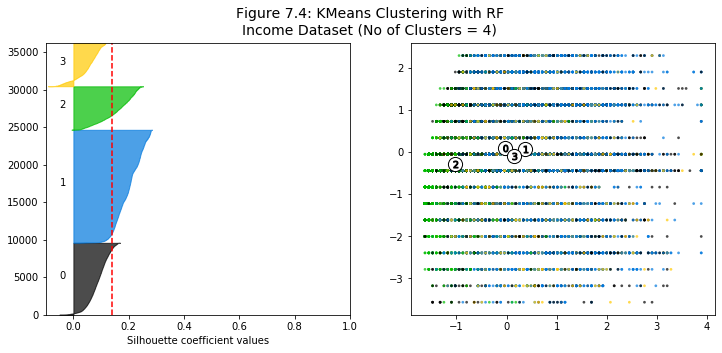

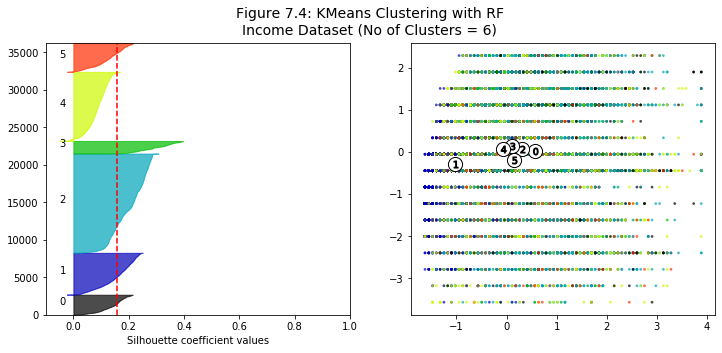

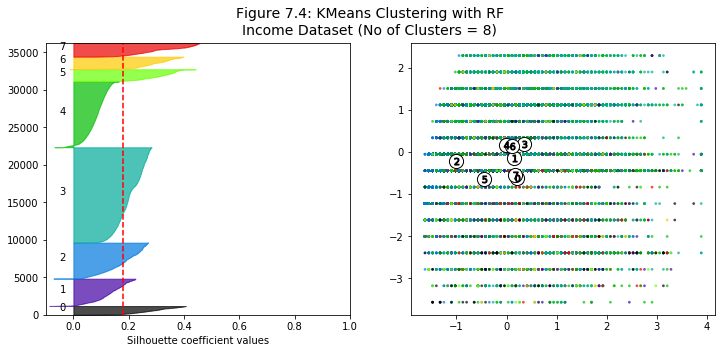

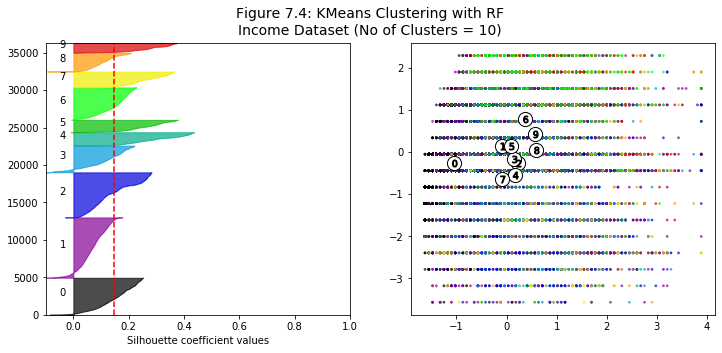

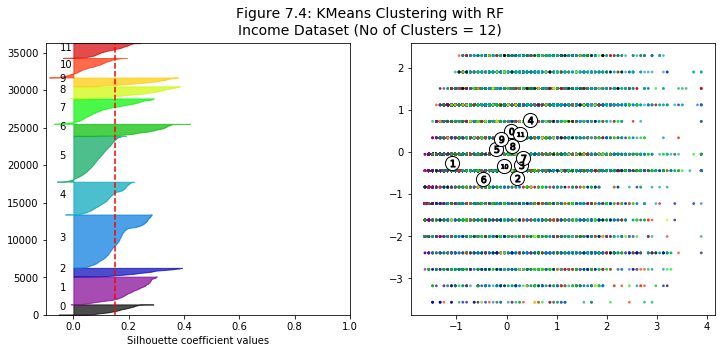

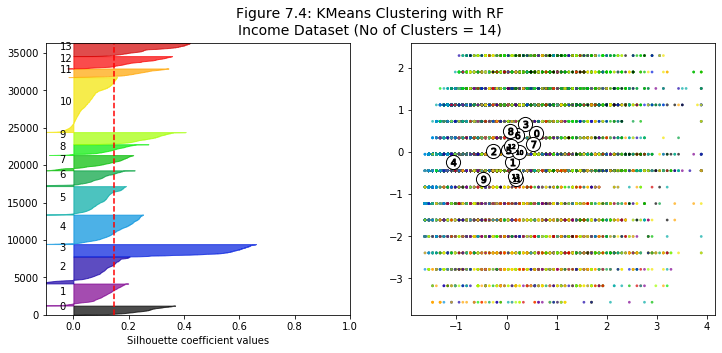

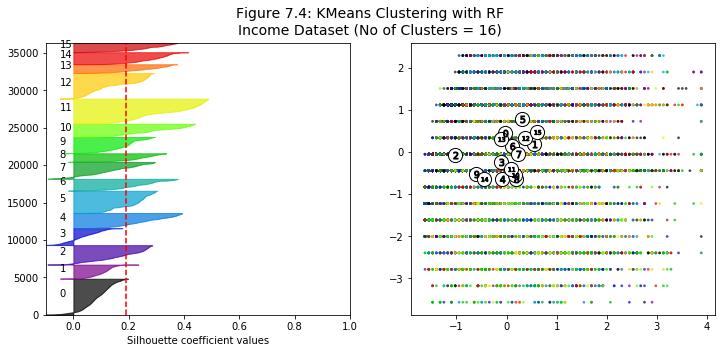

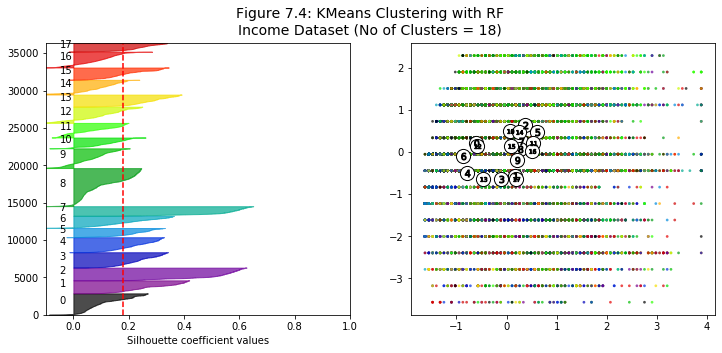

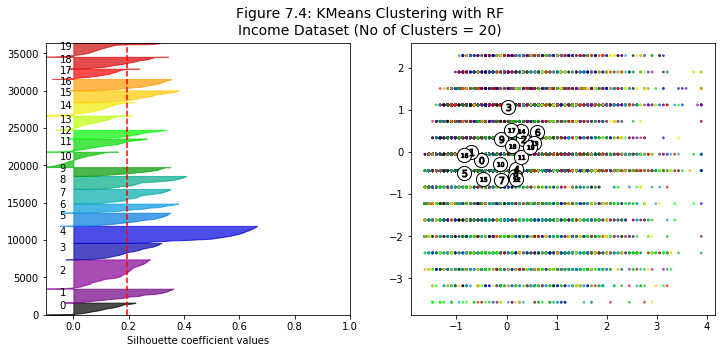

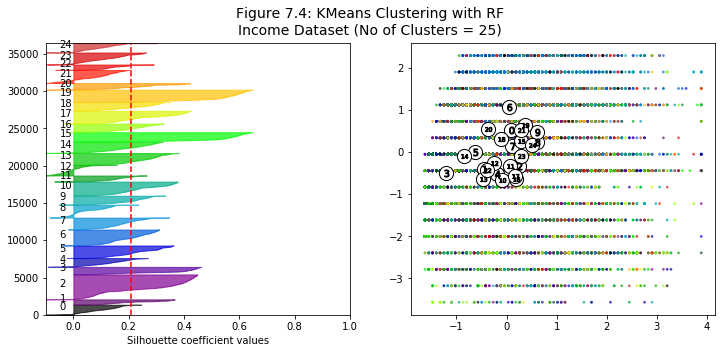

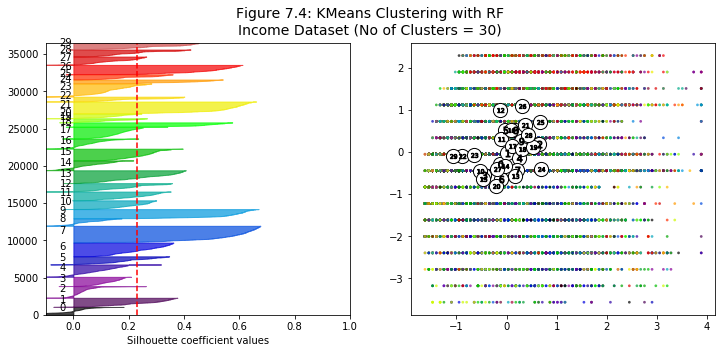

CV Type:  spherical  Components:  2  BIC Score:  3155204.028818856
CV Type:  spherical  Components:  4  BIC Score:  3025094.1382223754
CV Type:  spherical  Components:  6  BIC Score:  2946091.7199722263
CV Type:  spherical  Components:  8  BIC Score:  2848359.6696788864
CV Type:  spherical  Components:  10  BIC Score:  2776518.417764349
CV Type:  spherical  Components:  12  BIC Score:  2619968.1231891536
CV Type:  spherical  Components:  14  BIC Score:  2621102.596302614
CV Type:  spherical  Components:  16  BIC Score:  2515116.1417451296
CV Type:  spherical  Components:  18  BIC Score:  2534939.2915649754
CV Type:  spherical  Components:  20  BIC Score:  2344056.39136436
CV Type:  spherical  Components:  25  BIC Score:  2255135.688826514
CV Type:  spherical  Components:  30  BIC Score:  2185987.6409853664
CV Type:  tied  Components:  2  BIC Score:  2064502.2242727114
CV Type:  tied  Components:  4  BIC Score:  1546255.483639819
CV Type:  tied  Components:  6  BIC Score:  1442988.25376

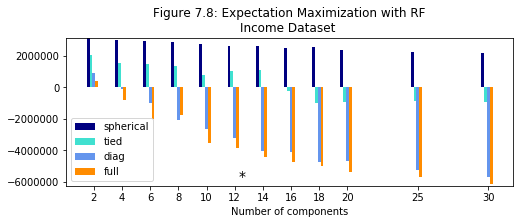

In [22]:
#random.seed(55)
titles = ["Figure 7.1: KMeans Clustering with PCA\nIncome Dataset ",
          "Figure 7.2: KMeans Clustering with ICA\nIncome Dataset ",
          "Figure 7.3: KMeans Clustering with RP\nIncome Dataset ",
          "Figure 7.4: KMeans Clustering with RF\nIncome Dataset "]

titles_bic_1 = ["Figure 7.5: Expectation Maximization with PCA\nIncome Dataset ",
          "Figure 7.6: Expectation Maximization with ICA\nIncome Dataset ",
          "Figure 7.7: Expectation Maximization with RP\nIncome Dataset ",
          "Figure 7.8: Expectation Maximization with RF\nIncome Dataset "]

titles_bic_2 = "Cluster Representation"

algo_name = ['PCA', 'ICA', 'RP', 'RF']
for i in range(len(algo_name)):
    temp = pd.read_hdf('datasets.hdf','Income_'+algo_name[i]) 
    #print(temp.columns)
    tempX = temp.drop('Class',1).copy().values
    tempY = temp['Class'].copy().values
    
    tempX = StandardScaler().fit_transform(tempX)
    
    KM_Silhoutte(tempX, tempY, titles[i])
    compute_bic_score(tempX , titles_bic_1[i], titles_bic_2)

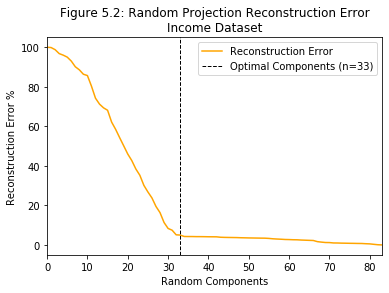

In [32]:
rc_results = pd.read_csv("./P2/IncomeRP_Reconstruction.csv", header = 'infer')
rc_results = rc_results['Reconstruction'] * 100.0
rc_results.plot( color = 'orange',  label = "Reconstruction Error" )
plt.axvline(x=33 , linestyle = "--", linewidth = 1, color = "k", label = "Optimal Components (n=33)")

plt.legend(loc='best')
plt.title("Figure 5.2: Random Projection Reconstruction Error\nIncome Dataset")
plt.xlabel("Random Components")
plt.ylabel("Reconstruction Error %");
plt.show()
plt.close()
